# CASE 3: **Lorentz-63 attractor**

### 1. Inizialization

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as kB
from numpy.random import randn as gauss
from numpy.random import rand as uniform

case_study = 'lorentz'

### 2. Generate Trajectories


Here it's defined the function that simulates the motion of the Brownian particle in the force field. Particularly, in this case of study, we consider a Brownian particle in a double well trap. The trajectory of the particle depends on two target parameters: the equilibrium distance L and the potential energy barrier height H.

Comments:

1. The function that simulates the trajectories is *simulate_trajectory*.
2. Lambda functions scale_inputs, rescale_inputs, scale_targets, and rescale_targets must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [3]:
sigma0 = 10                               
rho0 = 28                             
beta0 = 2.667
eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
R = 1e-7                                # Radius of the Brownian particle [m]
T = 300
gamma0 = 6 * np.pi * eta * R            # Reference friction coefficient [kg s^-1]

### Simulation parameters
N = 3000                   # Number of samples of the trajectory
Dt = 1e-2                  # Timestep 
oversampling = 5           # Simulation oversampling
offset = 1000              # Number of equilibration timesteps
batch_size = 32            # Number of trajectories

### Define functions to scale and rescale inputs
scale_inputs = lambda x, y, z: [x * 1e+6, y * 1e+6, z * 1e+6]        # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x, scaled_y, scaled_z: [scaled_x * 1e-6,
                            scaled_y * 1e-6, scaled_z * 1e-6]     # Rescales input trajectory to physical units

### Define function to scale and rescale targets
scale_targets = lambda sigma, rho, beta: [sigma, rho, beta]                        # Scales targets to order 1
rescale_targets = lambda scaled_sigma, scaled_rho, scaled_beta: [scaled_sigma, 
                                                                 scaled_rho, 
                                                                 scaled_beta] # Inverse of targets_scaling

def simulate_trajectory(batch_size=batch_size, 
                sigma0=sigma0,
                rho0=rho0,
                beta0=beta0,
                T=T,
                N=N, 
                Dt=Dt, 
                oversampling=oversampling, 
                offset=offset):

    ### Randomize trajectory parameters
    sigma = sigma0 * (uniform(batch_size)+.5)
    rho = rho0 * (uniform(batch_size)+.5)
    beta = beta0 * (uniform(batch_size)+.5)
    gamma = gamma0 * (uniform(batch_size) * .1 + .95)   # Marginal randomization of friction coefficient to tolarate small changes

    ### Simulate
    dt = Dt / oversampling                 # time step of the simulation
    x = np.zeros((batch_size, N))          # initialization of the x array
    y = np.zeros((batch_size, N))          # initialization of the y array
    z = np.zeros((batch_size, N))          # initialization of the z array
    D = kB * T / gamma                     # diffusion coefficient
    C1 = sigma #* dt                            # sigma
    C2 = rho #* dt                              # rho
    C3 = beta #* dt                             # beta
    C4 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
    X = x[:, 0]
    Y = y[:, 0]
    Z = z[:, 0]
    n = 0

    for t in range(offset):                      # Offset (for some prerun before running)
        X = X + C1*(Y-X)*dt + C4*gauss(batch_size)
        Y = Y + (C2*X-Y-X*Z)*dt + C4*gauss(batch_size)
        Z = Z + (X*Y - C3*Z)*dt + C4*gauss(batch_size)

    for t in range(N * oversampling):            # Simulation 
        X = X + C1*(Y-X)*dt + C4*gauss(batch_size)
        Y = Y + (C2*X-Y-X*Z)*dt + C4*gauss(batch_size)
        Z = Z + (X*Y - C3*Z)*dt + C4*gauss(batch_size) 
            
        if t % oversampling == 0:                # We save every oversampling^th values 
            x[:, n] = X 
            y[:, n] = Y
            z[:, n] = Z
            n += 1
            
    inputs = np.swapaxes([x, y, z],0,1)
    inputs_real = np.swapaxes([x, y, z],0,1)
    targets = np.swapaxes([sigma, rho, beta],0,1)
    target_reals = np.swapaxes([sigma, rho, beta],0,1)

    return inputs, inputs_real, targets, target_reals

<class 'numpy.ndarray'>


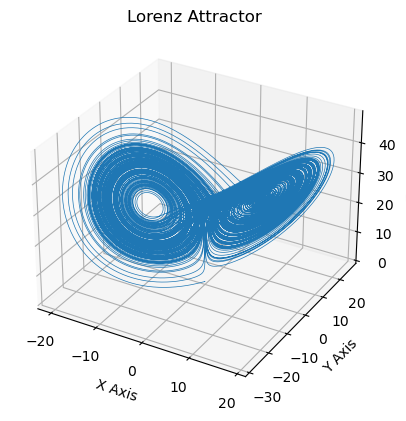

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 100000
batch_size=1

eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
R = 1e-7
T = 300
gamma0 = 6 * np.pi * eta * R
Dt = 1e-2                  # Timestep 
oversampling = 5
gamma = gamma0 * (uniform(batch_size) * .1 + .95)
dt = Dt / oversampling
D = kB * T / gamma
C4 = np.sqrt(2 * D * dt)



xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0,0,0)#(0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
#for t in range(offset):
#    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt + C4 * gauss(batch_size)

for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt + C4 * gauss(batch_size)

print(type(xyzs))

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

### 3. Plot Trajectory Simulation

In [ ]:
def plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show):
    """
    
    Inputs:   
    
    simulate_trajectory:                 trajectroy generator function
    number_of_trajectories_to_show:      number of trajectories to be plotted as sample  
        
    Output:
    
    This function does not return any outputs, it only plots some sample trajectories to preview the generator function
   
    """ 
    import matplotlib.pyplot as plt
    inputs, targets = simulate_trajectory(number_of_trajectories_to_show)
    
    if len(inputs.names)>1:
        for scaled_values, scaled_targets, target_values in zip(inputs.scaled_values, targets.scaled_values, targets.values):
            plt.figure(figsize=(20, 5))    
            number_subplots = len(inputs.names)
            for subplot in range(number_subplots):
                plt.subplot(1, number_subplots, subplot+1)
                plt.plot(scaled_values[subplot])
                plt.xlabel('timestep', fontsize=18)
                plt.ylabel(inputs.scalings[subplot], fontsize=18)   

            title_text = 'Parameters: ' 
            for parameter in range(len(target_values)):
                title_text +=  ', ' + targets.names[parameter] + ' = ' + '%1.2e' % target_values[parameter]
            plt.title(title_text, fontsize=18)  

    else:
        for scaled_values, scaled_targets, target_values in zip(inputs.scaled_values, targets.scaled_values, targets.values):
            plt.figure(figsize=(20, 5))
            plt.plot(scaled_values)
            plt.xlabel('timestep', fontsize=18)
            plt.ylabel(inputs.scalings[0], fontsize=18)
            title_text = 'Parameters: ' 
            if len(targets.names)>1:
                for parameter in range(len(targets.names)):
                    title_text +=  ', ' + targets.names[parameter] + ' = ' + '%1.2e' % target_values[parameter]
                plt.title(title_text, fontsize=18)  
            else:
                plt.title(title_text + ' ' + targets.names[0] + ' = ' + '%1.2e' % target_values , fontsize=18)  

In [ ]:
### Show some examples of simulated trajectories
number_of_trajectories_to_show= 10
plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

(10000,)
(10000,)


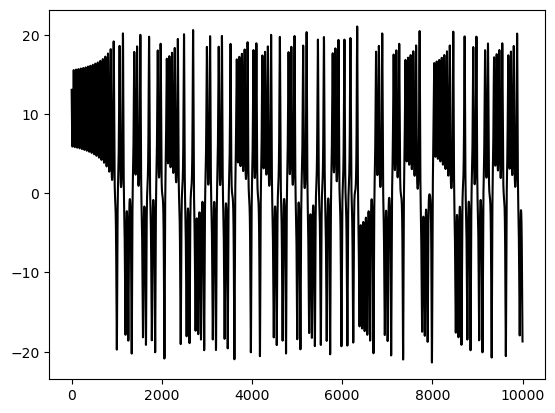

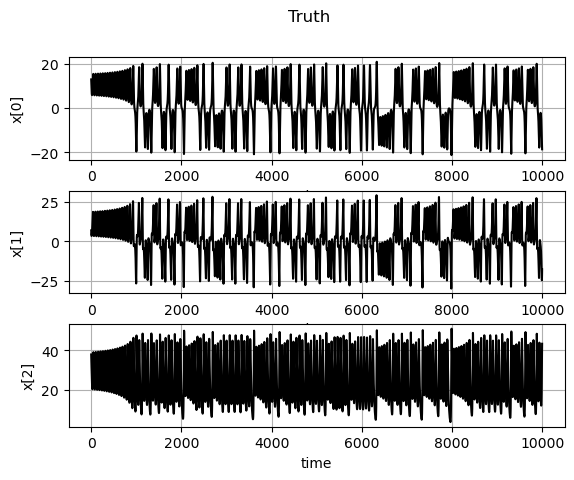

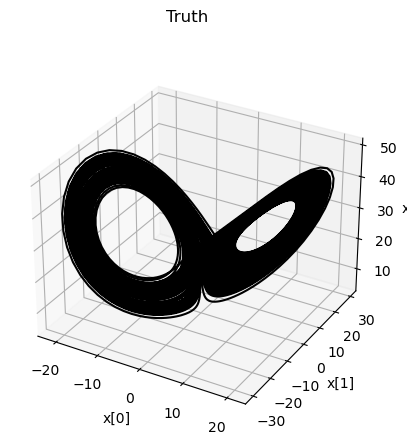

In [4]:
xt = simulate_trajectory()[0][2].T
print(xt[:,1].shape)
t = np.arange(0,10000) 
print(t.shape)

plt.plot(t,xt[:,0],'k')
plt.show()

plt.figure().suptitle('Truth')
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t,xt[:,i],'k')
    plt.ylabel('x['+str(i)+']')
    plt.xlabel('time')
    plt.grid(True)
    plt.subplots_adjust(hspace=0.3)

fig = plt.figure()
fig.suptitle('Truth')
ax = fig.add_subplot(111, projection='3d')
ax.plot(xt[:,0],xt[:,1],xt[:,2],'k')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_zlabel('x[2]')
ax.grid(True)

(3, 3000)


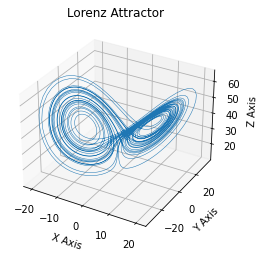

In [6]:
xyzs = simulate_trajectory()[0]
print(xyzs[0].shape)

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs[0], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

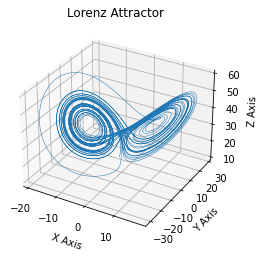

In [4]:
# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs[9], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

### 4. COMPILE Deep Neural Network

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.

Comments:

1. The parameter input_shape determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter conv_layers_dimensions determines the number and size of LSTM layers.
3. The parameter number_of_outputs determines the number of outputs, i.e. the number of force field parameters to be estimated.

#### RNN with attention

CREATE MODEL

In [7]:
from src_models import models_DNN, train_DNN, test_DNN

In [11]:
### Define parameters of the deep learning network
input_shape = (180, 50)      
gru_layers_dimensions = (250, 50)
number_of_outputs = 3

DNN = 'SimpleRNN'
attention = True

### Create deep learning network
network = models_DNN.create_deep_learning_network(input_shape, gru_layers_dimensions, number_of_outputs, 
                                                      DNN,
                                                      attention)

### Print deep learning network summary
network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 50)]         0         
                                                                 
 lstm_0 (LSTM)               (None, 180, 250)          301000    
                                                                 
 lstm_1 (LSTM)               (None, 180, 50)           60200     
                                                                 
 attention_1 (Attention)     (None, 50)                230       
                                                                 
 output (Dense)              (None, 3)                 153       
                                                                 
Total params: 361,583
Trainable params: 361,583
Non-trainable params: 0
_________________________________________________________________


In [12]:
# save DNN
save_dnn_name = 'Network-model_{}_{}'.format(DNN, case_study)

#if normal_values == False:
#    save_dnn_name = save_dnn_name + '_B'
if attention == True:
    save_dnn_name = save_dnn_name + '_attention'

network.save(save_dnn_name+'.h5')

### 5. TRAIN Deep Neural Network

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:

The parameter sample_sizes determines the sizes of the batches of trajectories used in the training.
The parameter iteration_numbers determines the numbers of batches used in the training.
The parameter verbose determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [13]:
%%time

sample_sizes = (32,128, 512) 
iteration_numbers = (3001, 2001, 1001)
verbose = .1

training_history = train_DNN.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size     32   iteration number      1   MSE   290.5556   MAE    12.7593   Time 3074.853659 ms
Sample size     32   iteration number     11   MSE   246.4321   MAE    11.7514   Time 768.321753 ms
Sample size     32   iteration number     21   MSE   192.2405   MAE    10.0256   Time 820.518494 ms
Sample size     32   iteration number     31   MSE   181.6384   MAE     9.4357   Time 770.149946 ms
Sample size     32   iteration number     41   MSE   161.3312   MAE     9.0408   Time 790.414333 ms
Sample size     32   iteration number     51   MSE   106.5974   MAE     7.3234   Time 804.758310 ms
Sample size     32   iteration number     61   MSE   111.3585   MAE     7.4093   Time 826.257944 ms
Sample size     32   iteration number     71   MSE   131.2197   MAE     8.0066   Time 762.337208 ms
Sample size     32   iteration number     81   MSE   123.8736   MAE     7.6567   Time 721.907616 ms
Sample size     32   iteration number     91   MSE   105.5001   MAE     6.5244   Time 765.808344 ms

### 6. TEST MODEL

In [14]:
%%time

number_of_predictions_to_show = 1000
prediction_test = test_DNN.test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

1/1 [==============================] - 0s 40ms/step
CPU times: total: 1min 40s
Wall time: 1min 21s


### 7. Store Training and Predicted history

In [15]:
import pickle
def save_data(a, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(a, f) #, protocol=pickle.HIGHEST_PROTOCOL)
    # close file
    f.close()

#from datetime import datetime
#date = datetime.today().strftime('%Y-%m-%d')

## file name
name_train = 'training_history_{}_{}'.format(DNN, case_study)
name_pred = 'prediction_{}_test_{}'.format(DNN, case_study)

#if normal_values == False:
#    name_train = name_train + '_B'
#    name_pred = name_pred + '_B'
if attention == True:
    name_train = name_train + '_attention'
    name_pred = name_pred + '_attention' 

# save train data
save_data(training_history, name_train)
# save test data
save_data(prediction_test, name_pred)

#load
#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

### 8. Plot results

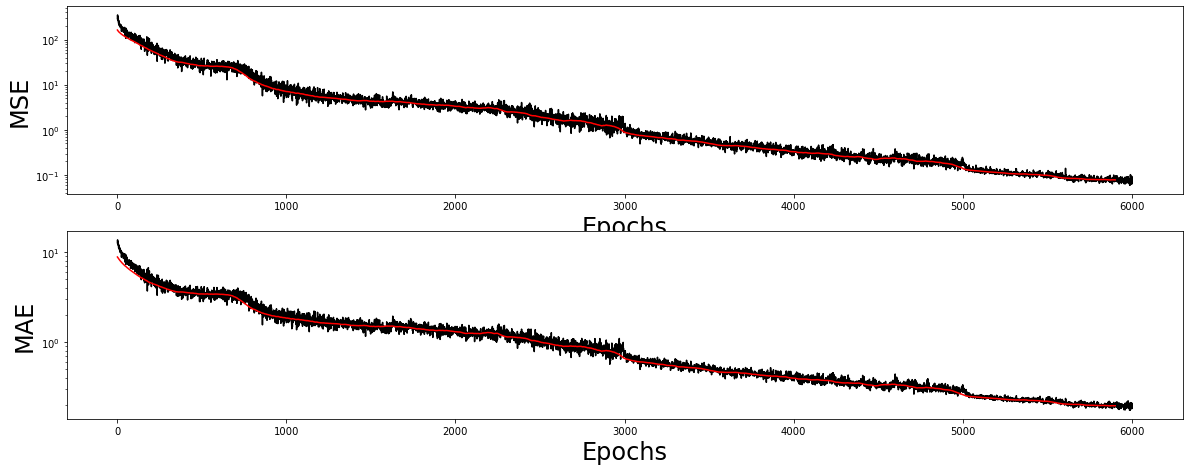

In [16]:
### Plot learning performance
number_of_timesteps_for_average = 100
train_DNN.plot_learning_performance(training_history, number_of_timesteps_for_average)

In [17]:
# average MSE and MAE
avg_mae= round(sum(training_history["MAE"])/len(training_history["MAE"]), 5)
avg_mse=round(sum(training_history["MSE"])/len(training_history["MSE"]), 5)
print('MSE: ',avg_mae)
print('MAE: ',avg_mae)

MSE:  1.29811
MAE:  1.29811


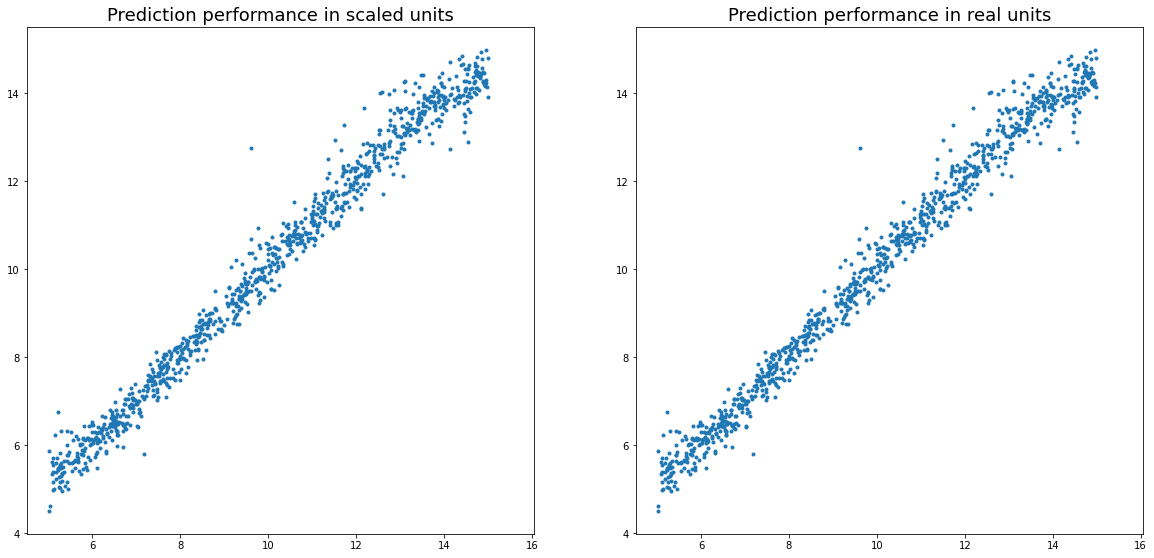

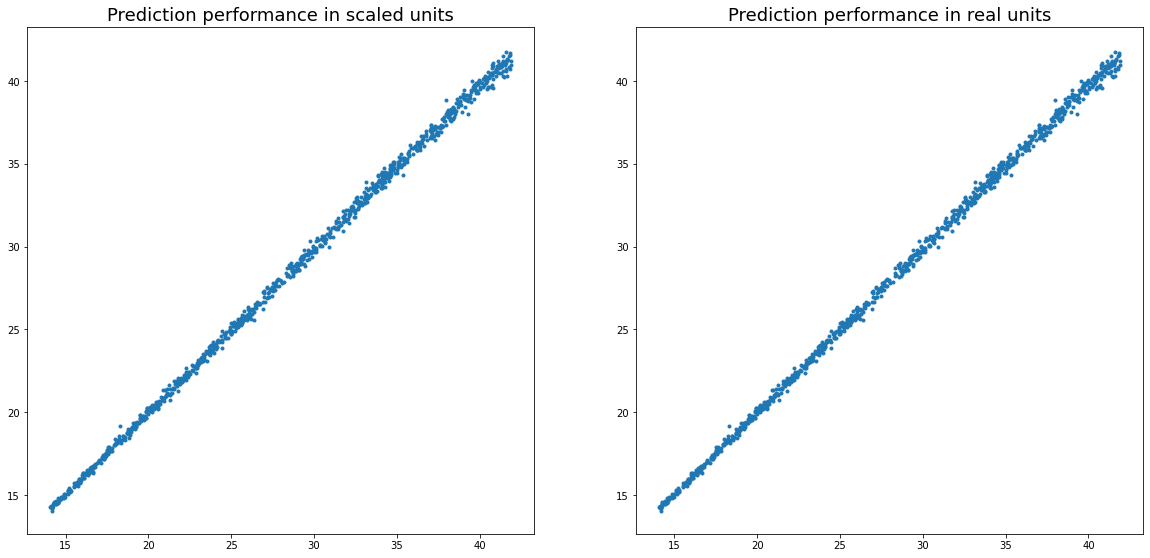

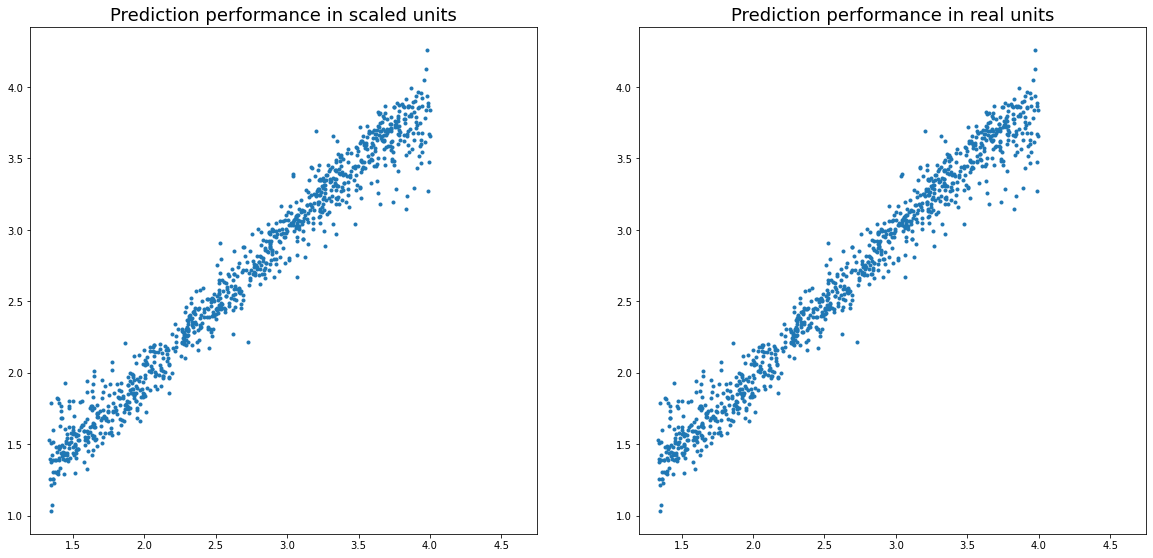

In [18]:
### Plot test performance
test_DNN.plot_test_performance(prediction_test[0], prediction_test[1], prediction_test[2], prediction_test[3], network)

In [18]:
# save DNN
save_dnn_name = 'Network-model_{}_{}'.format(DNN, case_study)

if normal_values == False:
    save_dnn_name = save_dnn_name + '_B'
if attention == True:
    save_dnn_name = save_dnn_name + '_attention'

network.save(save_dnn_name + '.h5')